## Purpose

The purpose of this notebook is to calculate the total amount of distance that Brightside has travelled in its lifetime. To do this, we simply query all of the velocity data we have and integrate it.

In [1]:
from data_tools.collections.time_series import TimeSeries
from data_tools.query.influxdb_query import DBClient
from datetime import datetime, timezone, timedelta
from scipy import integrate as intg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

client = DBClient()

ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_USERNAME in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_PASSWORD in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_DATABASE in .env!
ERROR:data_tools.query.postgresql_query:Could not find a POSTGRESQL_ADDRESS in .env!


Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


In [3]:
def distance_covered(vel: TimeSeries):
    dist_m = intg.simpson(vel) # integrate to find distance in m
    distance_mi = dist_m/(1609.344) # convert to miles
    
    return distance_mi

## Comparison of two Speeds

We have the speed data saved in two forms: VehicleVelocity(m/s), and MotorRotatingSpeed(km/hr). There are time ranges where we have data of both types (during competition in 2024), so I just want to make sure that the conversion stays consistent in this case.

In [4]:
# Querying data
start_date = datetime(2024, 7, 13)
end_date = datetime(2024, 7, 20)

start_time = datetime.combine(start_date, datetime.min.time(), tzinfo=timezone.utc)
end_time = datetime.combine(end_date, datetime.max.time(), tzinfo=timezone.utc)

# Query data
motor_speed: TimeSeries = client.query_time_series(start_time, end_time, "MotorRotatingSpeed", granularity = 1, units = "km/hr")
vehicle_velocity: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity", granularity = 1, units = "m/s")

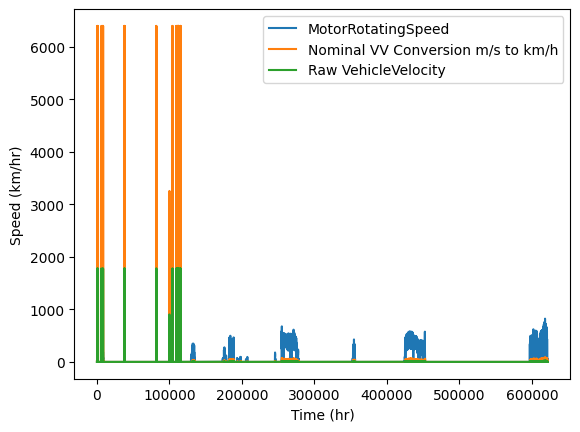

In [5]:
# Expected data with conversion
ms_to_kmh = 3.6 # 3.6 m/s = 1 km/hr
converted = vehicle_velocity * ms_to_kmh

plt.plot(motor_speed, label = "MotorRotatingSpeed")
plt.plot(converted, label = "Nominal VV Conversion m/s to km/h")
plt.plot(vehicle_velocity, label = "Raw VehicleVelocity")
plt.xlabel("Time (hr)")
plt.ylabel("Speed (km/hr)")
plt.legend()

The nominal conversion does not make the plots look similar. I believe there is a factor missing. Since motor speed can be recorded in rpm or some other measure of how fast the motor spins, I figure there could be a multiple of $\pi$ missing.

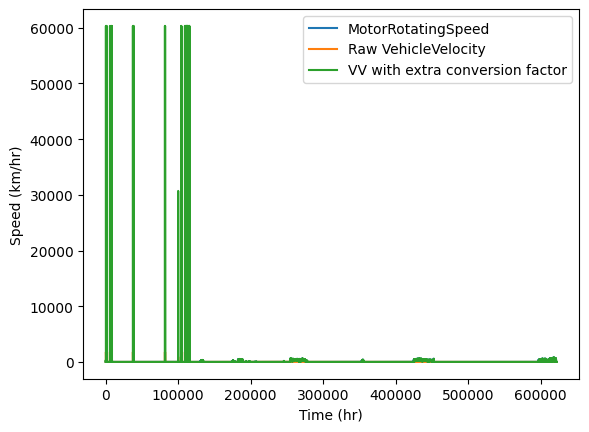

In [6]:
converted_mystery = vehicle_velocity * ms_to_kmh * 3 * np.pi # Adding extra conversion factor

plt.plot(motor_speed, label = "MotorRotatingSpeed")
plt.plot(vehicle_velocity, label = "Raw VehicleVelocity")
plt.plot(converted_mystery, label = "VV with extra conversion factor")
plt.xlabel("Time (hr)")
plt.ylabel("Speed (km/hr)")
plt.legend()

This new conversion factor seems to make VehicleVelocity align better with MotorRotatingSpeed.

## Mileage Calculation

The logic that we'll follow is that we will use VehicleVelocity(m/s) when available. Otherwise, we'll use MotorRotatingSpeed and convert.

In [7]:
kmh_to_ms = 0.277778

start_date = datetime(2024, 1, 1).date()      # Jan 1, 2024
end_date   = datetime.utcnow().date()    # Today (UTC)

current_day = start_date
while current_day <= end_date:
    # Start and endtime of the day
    start_time = datetime.combine(current_day, datetime.min.time(), tzinfo=timezone.utc)
    end_time   = start_time + timedelta(days=1)
    
    try:
        # Try to get velocity data
        vehicle_velocity: TimeSeries = client.query_time_series(
            start_time, end_time,
            "VehicleVelocity",
            granularity=1,
            units="m/s"
        )
        distance_today = distance_covered(vehicle_velocity)

    except Exception as e:
        # If query fails or returns empty
        try:
            motor_rotating_speed: TimeSeries = client.query_time_series(
            start_time, end_time,
            "MotorRotatingSpeed",
            granularity=1,
            units="km/hr"
        )
            
            speed_ms = motor_rotating_speed * kmh_to_ms
            distance_today = distance_covered(speed_ms)
        except Exception as e:
            # If everything fails set distance travelled to zero
            distance_today = 0.0

    # Save the result (date, distance)
    with open("daily_distance.csv", "a") as f:
        f.write(f"{current_day.isoformat()},{distance_today}\n")

    current_day += timedelta(days=1)

C:\Users\mikel\AppData\Local\Temp\ipykernel_16212\2103967788.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date   = datetime.utcnow().date()    # Today (UTC)


## Calculating Total Mileage

Now we must find the total number of miles that Brightside has travelled in its lifetime.

In [15]:
# Read csv
df = pd.read_csv("daily_distance.csv", header = None)

# Calculating total distance travelled
total_mileage = df.iloc[:, 1].sum()

print(f"Brightside's total mileage is {total_mileage} mi!")

Brightside's total mileage is 626.3232511861682 mi!


## Cumulative Sum

We plot a cumulative sum as a sanity check to make sure that our value makes sense.

In [30]:
# df [row/column][entry]

num_rows = df.shape[0]

days = []
cumulative_distances = []
cumulative_distance = 0
for i in range(num_rows):
    day = pd.to_datetime(df[0][i])
    days.append(day)
    
    distance_today = df[1][i]
    cumulative_distance += distance_today
    cumulative_distances.append(cumulative_distance)

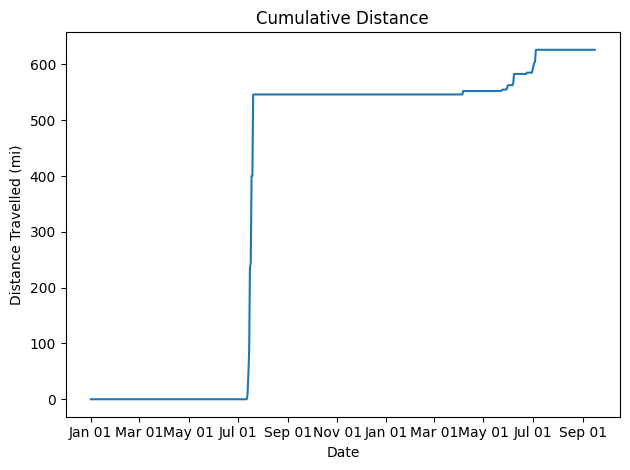

In [36]:
import matplotlib.dates as mdates

plt.title("Cumulative Distance")
plt.xlabel("Date")
plt.ylabel("Distance Travelled (mi)")
plt.plot(days, cumulative_distances)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())        # smart spacing
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d")) # e.g. 'Sep 01'
plt.tight_layout()
plt.show()

This seems to make sense. Looking at July 2024 specifically, we did:
- 98 laps at FSGP, which is about 98 * 3.4 (mi) = 333 mi
- About 142 mi at ASC
- Extra mileage while scrutineering

Note that the FSGP track is nominally 3.2 mi, but according to some of the previous analysis we have done we usually travelled a distance slightly higher than this. That is why I assumed a distance per lap of 3.4 mi.

## Brightside's Mileage: 626.3 mi ~ 196 FSGP Laps